# **PREPROCESSING🛠️**

In [ ]:
# Importing Keras
from keras.layers import Conv2D, GlobalAveragePooling2D  # Convolutional layer
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint   # Classes used to save weights and stop training when improvements reach a limit

# Importing TensorFlow
import tensorflow as tf

# Importing utils
import random
import plotly.subplots as sp
import plotly.graph_objs as go
import os
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import plotly.subplots as sp
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import matplotlib
import time

import matplotlib.pyplot as plt
import matplotlib

from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from glob import glob
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuring notebook
seed = 123
paper_color = '#EEF6FF'
bg_color = '#EEF6FF'

In [ ]:
# Function to load images
def convert_image_to_dataset(file_location):
    label = 0
    data_list = []

    for category in glob(file_location + '/*'):
        for file in tqdm(glob(category + '/*')):
            img_array = cv2.imread(file)
            img_array = cv2.resize(img_array, (224, 224))

            # add data to list
            data_list.append({'image': img_array, 'label': label})

        label += 1

    # Create dataframe
    df = pd.DataFrame(data_list)
    df = df.sample(frac=1).reset_index(drop=True)

    return df

In [ ]:
def inverse_classes(num):
    if num == 0:
        return 'Glioma Tumor'
    elif num == 1:
        return 'Meningioma Tumor'
    elif num == 2:
        return 'No Tumor'
    else:
        return 'Pituitary Tumor'

In [ ]:
def image_resizer(paths):
    """
    This function resizes the input images
    """
    with ThreadPoolExecutor() as executor:
        resized_images = list(executor.map(lambda x: Image.open(x).resize((350,250)), paths))
    return resized_images

def plot_images_list(images, title, subtitle):
    '''
    This functions helps to plot a matrix of images in a list
    '''
    fig = sp.make_subplots(rows=3, cols=3)
    images = image_resizer(images)

    traces = []
    for i in range(min(9, len(images))):
        img = go.Image(z=images[i])
        traces.append((img, i//3+1, i%3+1))

    fig.add_traces([trace[0] for trace in traces],
                  rows = [trace[1] for trace in traces],
                  cols = [trace[2] for trace in traces])

    fig.update_layout(
        title={'text': f'<b>{title}<br>  <i><sub>{subtitle}</sub></i></b>',
               'font': dict(size = 22)},
        height=800,
        width=800,
        margin=dict(t=110, l=80),
        plot_bgcolor=bg_color,paper_bgcolor=paper_color
        #template=template
    )
    fig.show()

In [ ]:
# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        print('\nGPU Found! Using GPU...')
    except RuntimeError as e:
        print(e)
else:
    strategy = tf.distribute.get_strategy()
    print('Number of replicas:', strategy.num_replicas_in_sync)


GPU Found! Using GPU...


In [ ]:
# Set Dataset path
train_dir = '/content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Training'
test_dir = '/content/drive/MyDrive/DEEP LEARNING/brain_tumor_dataset/Testing'

# Giving names to each directory
directories = {
    train_dir: 'Training',
    test_dir: 'Testing',
    }

# Naming subfolders
subfolders = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

print('\n* * * * * Number of files in each folder * * * * *\n')

# Counting the total of pictures inside each subfolder and directory
for dir, name in directories.items():
    total = 0
    for sub in subfolders:
        path = os.path.join(dir, sub)
        num_files = len([f for f in os.listdir(path) if os.path.join(path, f)])
        total += num_files
        print(f'\n{name}/{sub}: {num_files}')
    print(f'\n  Total: {total}')
    print("-" * 80)


* * * * * Number of files in each folder * * * * *


Training/glioma_tumor: 802

Training/meningioma_tumor: 707

Training/no_tumor: 246

Training/pituitary_tumor: 808

  Total: 2563
--------------------------------------------------------------------------------

Testing/glioma_tumor: 84

Testing/meningioma_tumor: 113

Testing/no_tumor: 81

Testing/pituitary_tumor: 36

  Total: 314
--------------------------------------------------------------------------------


In [ ]:
train_data = convert_image_to_dataset(train_dir)
train_x = np.array(train_data.image.to_list())
print("Dimensione di train_x:", train_x.shape)

test_data = convert_image_to_dataset(test_dir)
test_x = np.array(test_data.image.to_list())
print("Dimensione di test_x:", test_x.shape)

100%|██████████| 246/246 [00:01<00:00, 179.63it/s]


Dimensione di train_x: (2563, 224, 224, 3)


100%|██████████| 81/81 [00:00<00:00, 326.13it/s]

Dimensione di test_x: (314, 224, 224, 3)


In [ ]:
train_x = np.expand_dims(np.array(train_x) / 255.0, axis=-1)
test_x = np.expand_dims(np.array(test_x) / 255.0, axis=-1)

train_labels = np.array(train_data.label)
test_labels = np.array(test_data.label)

train_x, train_labels = shuffle(train_x, train_labels, random_state=42)
test_x, test_labels = shuffle(test_x, test_labels, random_state=42)

# **BUILDING THE CNN**🧠

In [ ]:
with strategy.scope():

    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Stacca l'ultimo layer (blocco) convoluzionale
    last_conv_layer = vgg_model.get_layer('block4_pool')
    conv_model = Model(inputs=vgg_model.input, outputs=last_conv_layer.output)

    # Visualizza la struttura del nuovo modello
    conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
with strategy.scope():
  for layers in vgg_model.layers:
    layers.trainable = False

  # Prendi l'output dal penultimo strato (blocco) convoluzionale
  x = GlobalAveragePooling2D()(conv_model.output)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5)(x)
  output = Dense(4, activation='softmax')(x)

  MyModel = Model(inputs=vgg_model.input, outputs=output)

#Visualizza la struttura del nuovo modello
MyModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Defining an Early Stopping and Model Checkpoints
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5, mode='max',
                               restore_best_weights=True)

checkpoint = ModelCheckpoint('tuned_weights2.h5',
                             monitor='val_accuracy',
                             save_best_only=True)

MyModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
with strategy.scope():
  start_time = time.time()
  try:
      history = MyModel.fit(
                            train_x,
                            train_labels,
                            validation_split=0.2,
                            epochs=50,
                            callbacks=[early_stopping, checkpoint],
                            batch_size=32
                            )

  except Exception as e:
      print("An error occurred:", e)

  end_time = time.time()
  interval = end_time - start_time
  print(f"Training phase Elapsed Time: {interval} seconds")

Epoch 1/50
65/65 [==============================] - 25s 173ms/step - loss: 0.9893 - accuracy: 0.6015 - val_loss: 0.6140 - val_accuracy: 0.7895
Epoch 2/50
65/65 [==============================] - 9s 137ms/step - loss: 0.6546 - accuracy: 0.7424 - val_loss: 0.5439 - val_accuracy: 0.7368
Epoch 3/50
65/65 [==============================] - 9s 134ms/step - loss: 0.5699 - accuracy: 0.7785 - val_loss: 0.4960 - val_accuracy: 0.8187
Epoch 4/50
65/65 [==============================] - 9s 145ms/step - loss: 0.5349 - accuracy: 0.7985 - val_loss: 0.4557 - val_accuracy: 0.7875
Epoch 5/50
65/65 [==============================] - 9s 136ms/step - loss: 0.5480 - accuracy: 0.8049 - val_loss: 0.4620 - val_accuracy: 0.8421
Epoch 6/50
65/65 [==============================] - 9s 141ms/step - loss: 0.4737 - accuracy: 0.8132 - val_loss: 0.4058 - val_accuracy: 0.8441
Epoch 7/50
65/65 [==============================] - 10s 149ms/step - loss: 0.4874 - accuracy: 0.8083 - val_loss: 0.4672 - val_accuracy: 0.7641
Epoc

In [ ]:
# Creating subplot
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=['<b>Loss Over Epochs</b>', '<b>Accuracy Over Epochs</b>'],
                    horizontal_spacing=0.2)

# Loss over epochs
train_loss = go.Scatter(x=list(range(len(history.history['loss']))),
                        y=history.history['loss'],
                        mode='lines',
                        line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                        name='Training',
                        showlegend = False)

val_loss = go.Scatter(x=list(range(len(history.history['val_loss']))),
                      y=history.history['val_loss'],
                      mode='lines',
                      line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                      name='Test',
                      showlegend = False)


fig.add_trace(train_loss, row=1, col=1)
fig.add_trace(val_loss, row=1, col=1)

# Accuray over epochs
train_acc = go.Scatter(x=list(range(len(history.history['accuracy']))),
                       y=history.history['accuracy'],
                       mode='lines',
                       line=dict(color='rgba(0, 67, 162, .75)', width=4.75),
                       name='Training',
                       showlegend = True)

val_acc = go.Scatter(x=list(range(len(history.history['val_accuracy']))),
                     y=history.history['val_accuracy'],
                     mode='lines',
                     line=dict(color='rgba(255, 132, 0, .75)', width=4.75),
                     name='Validation',
                     showlegend = True)


fig.add_trace(train_acc, row=1, col=2)
fig.add_trace(val_acc, row=1, col=2)

# Updating layout
fig.update_layout(
    title={'text': '<b>Loss and Accuracy Over Epochs</b>', 'x': 0.025, 'xanchor': 'left'},
    margin=dict(t=100),
    plot_bgcolor=bg_color,paper_bgcolor=paper_color,
    height=500, width=1000,
    showlegend= True
)

fig.update_yaxes(title_text = 'Loss', row = 1, col = 1)
fig.update_yaxes(title_text = 'Accuracy', row = 1, col = 2)

fig.update_xaxes(title_text = 'Epoch', row = 1, col = 1)
fig.update_xaxes(title_text = 'Epoch', row = 1, col = 2)

# Showing figure
fig.show()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

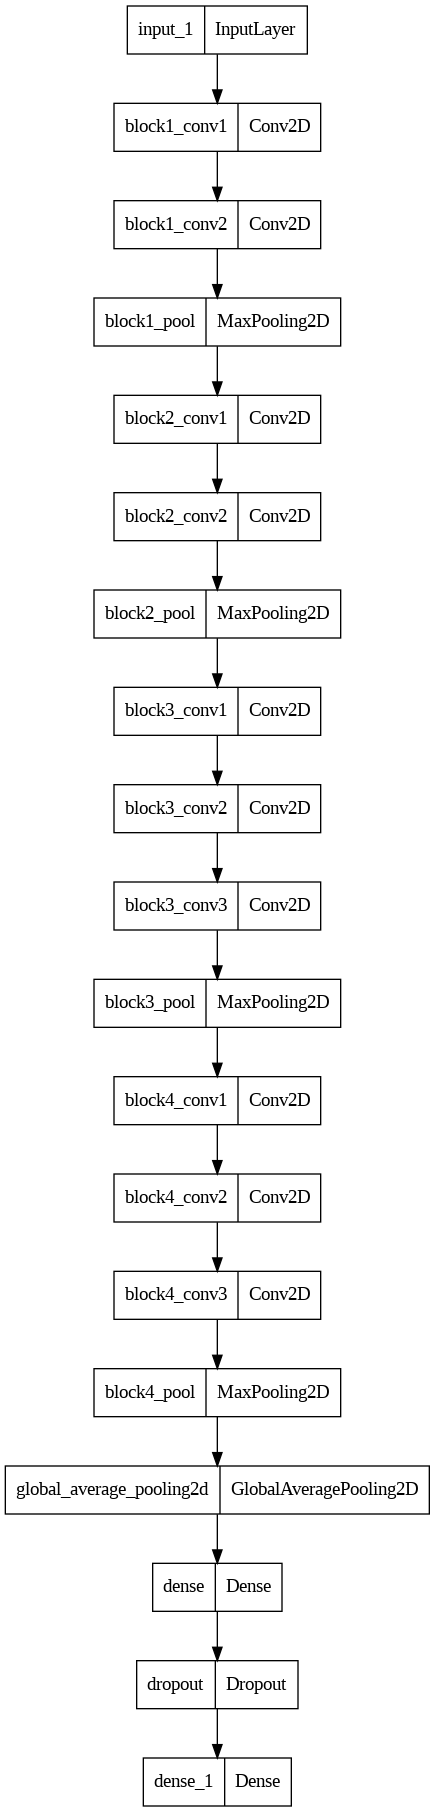

In [ ]:
# Model summary
MyModel.summary() # Printing model summary
tf.keras.utils.plot_model(MyModel) # Plotting model

# **VALIDATE🧾**

In [ ]:
# Loading best weights
MyModel.load_weights('tuned_weights2.h5')

In [ ]:
preds = MyModel.predict(test_x, batch_size=32)  # Running model on the test dataset
test_loss, test_acc = MyModel.evaluate(test_x, test_labels) # Obtaining Loss and Accuracy on the test dataset

print('\nTest Loss: ', test_loss)
print('\nTest Accuracy: ', np.round(test_acc * 100), '%')

10/10 [==============================] - 1s 114ms/step - loss: 2.2789 - accuracy: 0.4045

Test Loss:  2.2789113521575928

Test Accuracy:  40.0 %


0      3
1      1
2      1
3      2
4      1
      ..
309    1
310    2
311    3
312    1
313    2
Name: label, Length: 314, dtype: int64


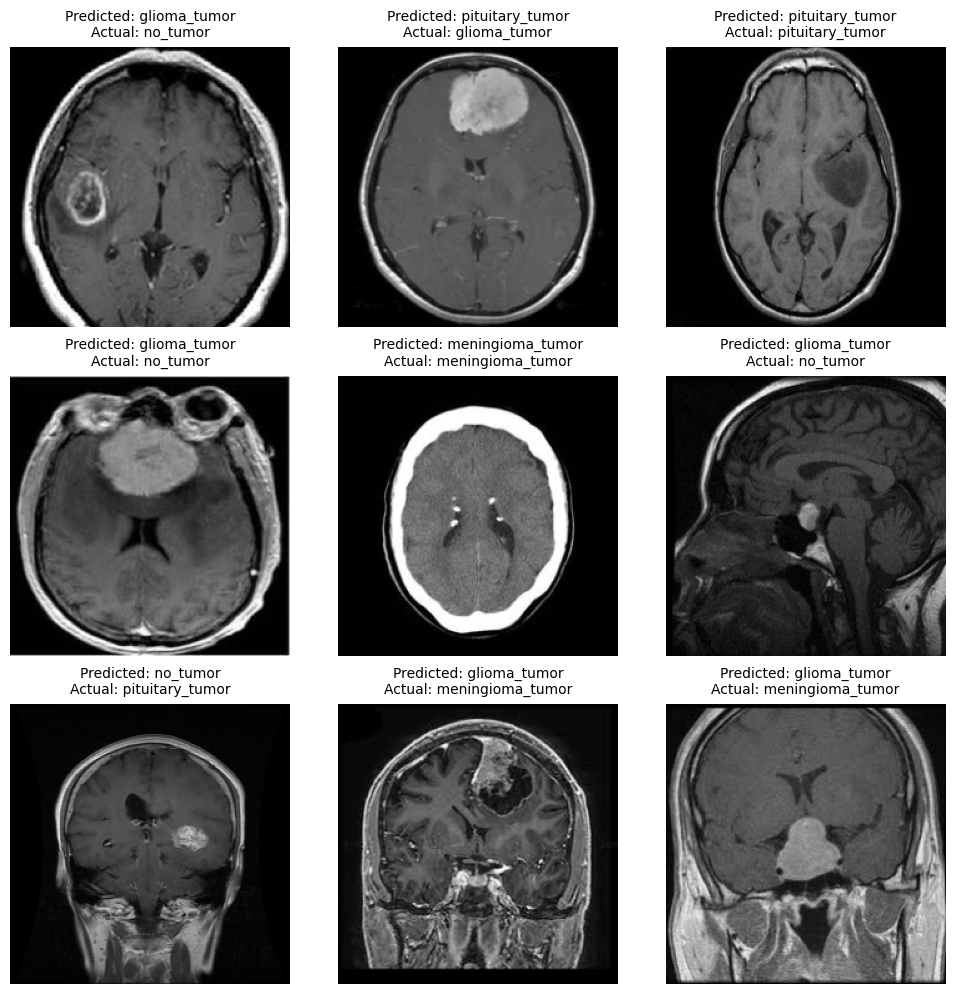

In [ ]:
y_pred_classes = np.argmax(preds, axis=1)
y_true_classes = (test_data.label.values)
print(test_data.label)

labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Choose 9 firt images
num_images_to_display = 9
indices_to_display = np.random.choice(len(test_x), num_images_to_display, replace=False)

# Create 3x3 graph
plt.figure(figsize=(10, 10))
for i, index in enumerate(indices_to_display, 1):
    plt.subplot(3, 3, i)
    plt.imshow(test_x[index, :, :, 0], cmap='gray')
    predicted_label = labels[y_pred_classes[index]]
    true_label = labels[y_true_classes[index]]
    plt.text(0.5, 1.08, f'Predicted: {predicted_label}\nActual: {true_label}',
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=plt.gca().transAxes)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Saving model
MyModel.save('tuned_model.h5')